In [17]:
import numpy as np
import pandas as pd
import pytest
import math

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import clone

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

import doubleml as dml
from doubleml.datasets import make_irm_data_discrete_treatements, make_irm_data

In [18]:
n_levels = 5
data_apo_large = make_irm_data_discrete_treatements(n_obs=int(1e+6), n_levels=n_levels)

y0 = data_apo_large['oracle_values']['y0']
cont_d = data_apo_large['oracle_values']['cont_d']
ite = data_apo_large['oracle_values']['ite']
d = data_apo_large['d']
potential_level = data_apo_large['oracle_values']['potential_level']
level_bounds = data_apo_large['oracle_values']['level_bounds']

average_ites = np.full(n_levels + 1, np.nan)
apos = np.full(n_levels + 1, np.nan)
mid_points = np.full(n_levels, np.nan)

for i in range(n_levels + 1):
    average_ites[i] = np.mean(ite[d == i])
    apos[i] = np.mean(y0) + average_ites[i]

print(f"Average Individual effects in each group:\n{average_ites}")
print(f"Average Potential Outcomes in each group:\n{apos}")


Average Individual effects in each group:
[-3.88013159e-03 -1.14938630e+01 -4.88788601e+00  1.41571898e-01
  5.04010656e+00  1.10085882e+01]
Average Potential Outcomes in each group:
[209.99642694 198.50644402 205.11242106 210.14187896 215.04041363
 221.00889529]


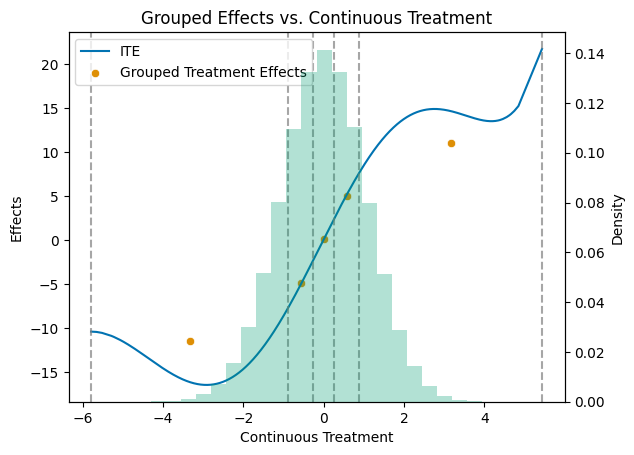

In [21]:


# Get a colorblind-friendly palette
palette = sns.color_palette("colorblind")

df = pd.DataFrame({'cont_d': cont_d, 'ite': ite})
df_sorted = df.sort_values('cont_d')

mid_points = np.full(n_levels, np.nan)
for i in range(n_levels):
    mid_points[i] = (level_bounds[i] + level_bounds[i + 1]) / 2

df_apos = pd.DataFrame({'mid_points': mid_points, 'treatment effects': apos[1:] - apos[0]})

# Create the primary plot with scatter and line plots
fig, ax1 = plt.subplots()

sns.lineplot(data=df_sorted, x='cont_d', y='ite', color=palette[0], label='ITE', ax=ax1)
sns.scatterplot(data=df_apos, x='mid_points', y='treatment effects', color=palette[1], label='Grouped Treatment Effects', ax=ax1)

# Add vertical dashed lines at level_bounds
for bound in level_bounds:
    ax1.axvline(x=bound, color='grey', linestyle='--', alpha=0.7)

ax1.set_title('Grouped Effects vs. Continuous Treatment')
ax1.set_xlabel('Continuous Treatment')
ax1.set_ylabel('Effects')

# Create a secondary y-axis for the histogram
ax2 = ax1.twinx()

# Plot the histogram on the secondary y-axis
ax2.hist(df_sorted['cont_d'], bins=30, alpha=0.3, weights=np.ones_like(df_sorted['cont_d']) / len(df_sorted['cont_d']), color=palette[2])
ax2.set_ylabel('Density')

# Make sure the legend includes all plots
lines, labels = ax1.get_legend_handles_labels()
ax1.legend(lines, labels, loc='upper left')

plt.show()

In [26]:
np.random.seed(42)
n_obs = 500
data_apo = make_irm_data_discrete_treatements(n_obs=n_obs, n_levels=n_levels)
y = data_apo['y']
x = data_apo['x']
d = data_apo['d']
df_apo = pd.DataFrame(
    np.column_stack((y, d, x)),
    columns=['y', 'd'] + ['x' + str(i) for i in range(data_apo['x'].shape[1])]
)

dml_data = dml.DoubleMLData(df_apo, 'y', 'd')

In [29]:
print(f"Levels and their counts:\n{np.unique(d, return_counts=True)}")

levels = np.unique(d)
ml_g = RandomForestRegressor(n_estimators=500)
ml_m = RandomForestClassifier(n_estimators=500)

Levels and their counts:
(array([0., 1., 2., 3., 4., 5.]), array([101,  82,  79,  79,  81,  78], dtype=int64))


In [35]:
np.random.seed(42)

thetas = np.full(n_levels + 1, np.nan)
ci = np.full((n_levels + 1, 2), np.nan)

for treatment_level in range(n_levels + 1):
    dml_obj = dml.DoubleMLAPO(dml_data,
                                ml_g, ml_m,
                                treatment_level=treatment_level,
                                score='APO')

    # synchronize the sample splitting
    dml_obj.fit()

    thetas[treatment_level] = dml_obj.coef[0]
    ci[treatment_level, :] = dml_obj.confint(level=0.95).values


c:\github\doubleml-for-py\doubleml\utils\_checks.py:204: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=500) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


In [37]:
df_apo = pd.DataFrame(
    {'treatment_level': range(n_levels + 1),
     'apo': apos,
     'theta': thetas,
     'ci_lower': ci[:, 0],
     'ci_upper': ci[:, 1]})

df_apo

,treatment_level,apo,theta,ci_lower,ci_upper
0,0,209.996427,211.052038,204.994819,217.109257
1,1,198.506444,201.400234,189.106993,213.693475
2,2,205.112421,204.711830,195.044139,214.379522
3,3,210.141879,208.834528,202.164795,215.504260
4,4,215.040414,217.811036,204.076666,231.545405
5,5,221.008895,218.861303,209.921383,227.801223


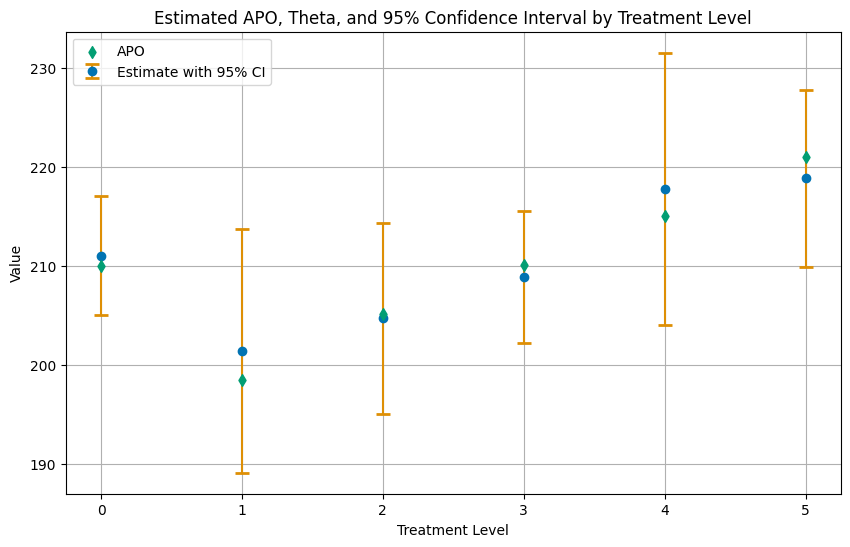

In [47]:
# Plotting
plt.figure(figsize=(10, 6))
# Plot Estimate with 95% CI
plt.errorbar(df_apo['treatment_level'], df_apo['theta'], 
             yerr=[df_apo['theta'] - df_apo['ci_lower'], df_apo['ci_upper'] - df_apo['theta']], 
             fmt='o', capsize=5, capthick=2, ecolor=palette[1], color=palette[0], label='Estimate with 95% CI', zorder=2)
# Plot APO as a scatter plot, with zorder set to 2 to be in front
plt.scatter(df_apo['treatment_level'], df_apo['apo'], color=palette[2], label='APO', marker='d', zorder=3)

plt.title('Estimated APO, Theta, and 95% Confidence Interval by Treatment Level')
plt.xlabel('Treatment Level')
plt.ylabel('Value')
plt.xticks(df_apo['treatment_level'])
plt.legend()
plt.grid(True)
plt.show()